In [21]:
#############################################################################
##
## Copyright (C) 2021 NVIDIA Corporation.  All rights reserved.
##
## NVIDIA Sample Code
##
##Please refer to the NVIDIA end user license agreement (EULA) associated
## with this source code for terms and conditions that govern your use of
## this software. Any use, reproduction, disclosure, or distribution of
## this software and related documentation outside the terms of the EULA
## is strictly prohibited.
##
#############################################################################

# Deep Autoencoder-Based Statistical Arbitrage During a Bearish Market 
## Authors: Onur Yilmaz, Ph.D. and Mark Bennett, Ph.D. of NVIDIA Financial Services

## Background material can be found at:
[A Primer for Financial Engineering] (https://web.njit.edu/~akansu/book5.htm)
[Financial Analytics with R] (http://cambridge.org/FAR)
<br>
<img src=nvidialogo.png/>
<br>

<br>
<img src="images/image001.png" width="1200"/>
<br>

Compare Gross, Net, Log Returns; 1st loss 𝑆(0)=100;𝑆(𝑡)=80 then gain 𝑆(0)=80;𝑆(𝑡)=100

In [22]:
# A) Try Gross Return:
80.0/100

0.8

In [23]:
# B) Try Net Return:
80.0/100.0-1

-0.19999999999999996

In [24]:
# C) Try Gross Return:
100.0/80.0

1.25

In [25]:
# D) Try Net Return:
100.0/80.0-1

0.25


---------------------------------------------------------------------------------------------------------

<b>QUESTION 1:</b>  Looking at the first chart, the worst performing stock of 2018 the Dow Jones 30 had
an approximate gross return of (pick one):

a) 1.4
b) 1.0
c) 0.4

---------------------------------------------------------------------------------------------------------


In [26]:
# E) Try Log Return:
import numpy as np
np.log(80.0/100.0)

-0.2231435513142097

In [27]:
# F) Try Log Return:
np.log(100.0/80.0)

0.22314355131420976

In general, log returns have been compared to the normal distribution quite often.

Well, there is some similarity but also differences. (These prices are quoted once per day.)

---------------------------------------------------------------------------------------------------------

<b>QUESTION 2:</b> If a security goes from a price of 100 down to 80 and back to 100 and we compute the 2
resulting returns, for which of the three return types (gross return, net return, log return) do we have the same absolute values in each of the 2 returns?

---------------------------------------------------------------------------------------------------------

The first pair of plots depict the normalized log returns of the actual and simulated Dow 30 with a color per security.
The second pair of plots show the density of each series, actual and simulated.
The third pair of plots is a visual depiction of the actual and simulated Dow 30 log return covaiannces.

<br><img src="images/Logrets.png"><br>

---------------------------------------------------------------------------------------------------------

<b>QUESTION 3:</b>  Looking at the 6 charts above and below, the left charts have
actual log returns from the Dow 30
securities prices and the right charts have
simulated log returns for a random variate generator for the
normal distribution. Which chart exhibits higher volatility? Wider tails? Higher covariance?

a) left
b) right

---------------------------------------------------------------------------------------------------------


<br><img src="images/LogretDensities.png"><br>

<br><img src="images/LogretCov.png"><br>

In [28]:
#These are the Python libraries:
from __future__ import division
from numba import cuda
import numpy
import math

import cudf,cupy
import tensorflow as tf
#from tensorflow import keras
import pandas as pd
import os, math, numpy
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import sys, time

import tensorflow as tf, pandas as pd, numpy as np
from sklearn.metrics import confusion_matrix, mean_squared_error
import os
import matplotlib.pyplot as plt
from numpy.random import seed

from keras import Sequential, Model
from keras.layers import Dense, Input, Dropout, Flatten
from tensorflow.compat.v1 import set_random_seed
from tensorflow.compat.v1 import disable_v2_behavior
if len(sys.argv)==1:
    if os.name != 'nt':
        import tensorflow.compat.v1 as tf
        tf.disable_v2_behavior()

#Arguments:
epochs = 10 #40 
isDAE = False; isRetrain = False
i = 1; isDAE = True; ErrorSignalWindow = 10; gpuNum = 0; noword = ''

In [29]:
numpy.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

GPUstr = '/GPU:'+str(gpuNum)
with tf.device(GPUstr):
  a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
  b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
  c = tf.matmul(a, b)
  print(c)

from cudf import concat,DataFrame,read_csv
from cupy import array,int32,float32,empty,zeros,vstack#,subtract,cumsum
from cupy import asarray,floor#notfast:divide,mean,std,log,cumsum,sum,floor
from numpy import subtract,cumsum
from numpy import divide,mean,std,log,isnan,sum,abs#,empty,zeros,cumsum,vstack

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [30]:
#Functions:
#Before we read the data and build the model,
#we defined the used functions in the lab.

#calculates the log-return of assets. Typically, a
#price data matrix that includes price of single
#asset or multiple assets in different columns are passed as an input.

def getReturn(data):
    [R, C] = data.shape
    dataND = data[1:R]
    dataTD = data[0:R-1]
    rts = log(divide(dataND, dataTD))
    return rts
#unit test:
getReturn(array([[1.3, 1.3],[1.2, 1.4],[1.3, 1.3]]))

#We standardize the log-returns (Z-score normalization) using the following function.
#They are normalized to zero mean and unit variance. One of the most commonly used technique,
#which is calculated using the arithmetic mean and standard deviation of the given data.
#Standardization is widely used in machine learning when the scale of the each feature in the set is different.
def normalizeReturn(data):
    data = divide((data - mean(data, axis=0)), std(data, axis=0))
    return data
testArr = array([[1.3, 1.3],[1.2, 1.4],[1.3, 1.3]])
print('2 simple time series of prices:')
print(testArr)
print(getReturn(testArr))
normalizeReturn(getReturn(testArr))

2 simple time series of prices:
[[1.3 1.3]
 [1.2 1.4]
 [1.3 1.3]]
[[-0.08004271  0.07410797]
 [ 0.08004271 -0.07410797]]


array([[-1.,  1.],
       [ 1., -1.]])

---------------------------------------------------------------------------------------------------------

<b>QUESTION 5:</b>  When using the getReturn() followed by normalizeReturn() on the security prices going
from 1.3 to 1.2 and back to 1.3 then what is our first value: Hint use the following: array([[1.3],[1.2],[1.3]])

a) 1
b) -1

---------------------------------------------------------------------------------------------------------


<br>
<img src="images/image002.png" width="1200"/>
<br>

<br>
<img src="images/image004.png" width="1200"/>
<br>

<br>
<img src="images/image005.png" width="1200"/>
<br>

<br>
<img src="images/image003.png" width="1200"/>
<br>

Here is the deep autoencoder definition below:

In [31]:
def getTrainedAutoencoderModel(hParams, trainData, GPUstr):
    seed(1)
    if os.name != 'nt':
        set_random_seed(23456)
    with tf.device(GPUstr):
        model = Sequential()
        model.add( Dense( hParams['inputOutputDimensionality'], activation = 'linear', input_shape=trainData.shape[1:]))
        model.add( Dense( hParams['hl1'], activation = 'relu'))
        model.add( Dense( hParams['hl2'], activation = 'sigmoid'))
        model.add( Dense( hParams['hl1'], activation = 'sigmoid'))
        model.add( Dense( hParams['inputOutputDimensionality'], activation = 'linear'))
        model.summary()
        model.compile(optimizer = 'adam', loss = 'mse')
        early_stopping = EarlyStopping( monitor = 'val_loss', patience = 10)
        checkpointer = ModelCheckpoint( filepath = 'synthetic_weights.hdf5',
                                       verbose=1, save_best_only = True)
        start = time.time()
        # Model is trained
        model.fit( trainData,
               trainData,
               batch_size = hParams['batchSize'],
               epochs = hParams['epochs'],
               shuffle = True,
               #callbacks = [early_stopping, checkpointer],
               validation_data = (trainData, trainData),
               verbose = 1 )
        print(trainData.shape,'is shape',GPUstr,'took',time.time() - start)
        sys.stdin.readlines()
        return model

Python then CuPy Raw Kernel versions

In [32]:
#Based on the current position, calculated spread, and the thresholds, trading signals will be generated.
def genTradingSignals(pos, spread, Ts, Ss, Ps, N):
    # Based on the spread, signal generation is similar to pairs trading
    newPos = zeros(shape=(1, N), dtype=int) # New position for each stock will be stored in this vector
    signal = zeros(shape=(1, N), dtype=int) # Generated signal to get to new position will be stored in this vector
    totalOpenedPos = 0
    #Embarrassingly parallel:
    for stock in range(0, N):
        if pos[stock] == Ps['NO_POSITION'] and spread[stock] > Ts['T1']:
            # If the stock has no position and the spread of the error signal above the threshold T1
            # Short position is opened because we expect the stock will go down to get back its normal behaviour (mean)
            signal[0, stock] = Ss['SHORT_SELL']
            newPos[0, stock] = Ps['SHORT']
        elif pos[stock] == Ps['NO_POSITION'] and spread[stock] < -Ts['T1']:
            # If the stock has no position and the spread of the error signal below the threshold -T1
            # Long position is opened because we expect the stock will go up to get back its normal behaviour (mean)
            signal[0, stock] = Ss['BUY']
            newPos[0, stock] = Ps['LONG']
        elif pos[stock] == Ps['SHORT'] and spread[stock] < Ts['T2']:
            # If the stock is in short position and the spread is below threshold T2,
            # that means it almost gets back to its normal behaviour and we close the position to generate profit
            signal[0, stock] = Ss['BUY_TO_COVER']
            newPos[0, stock] = Ps['NO_POSITION']
        elif pos[stock] == Ps['LONG'] and spread[stock] > -Ts['T2']:
            # that means it almost gets back to its normal behaviour and we close the position to generate profit
            signal[0, stock] = Ss['SELL']
            newPos[0, stock] = Ps['NO_POSITION']
        else:
            # Otherwise, no position is opened
            newPos[0, stock] = pos[stock]
            #print(stock)

        if newPos[0, stock] !=  Ps['NO_POSITION']:
            totalOpenedPos += 1
            #print('totalOpenedPos += 1',stock)
    return (newPos, signal, totalOpenedPos)

getTradingSignalKernel = cupy.RawKernel(r'''
extern "C" __global__
void getTradingSignalKernel(const int *pos, const double *spread,
      const float *Ts, int N, int *newPos, int *signal) { //, int *openedPos
    //def genTradingSignals(pos, spread, Ts, Ss, Ps, N): //Python header
    // Based on the spread, signal generation is similar to pairs trading
    //newPos = zeros(shape=(1, N), dtype=int) # New position for each stock will be stored in this vector
    //signal = zeros(shape=(1, N), dtype=int) # Generated signal to get to new position will be stored in this vector

    //for stock in range(0, N):
    //Embarrassingly parallel:
  int stock = blockDim.x * blockIdx.x + threadIdx.x;
  if(stock < N) {
  //for(int stock = 0; stock < N; stock++) { //nonparallel version
    signal[stock] = 0; //Acct for signal = zeros(shape=(1, N), dtype=int)
    newPos[stock] = 0; //Acct for newPos = zeros(shape=(1, N), dtype=int)
    //continue;
    if(pos[stock] == 0 /*Ps['NO_POSITION']*/ && spread[stock] > Ts[0]) { //Ts['T1']:
         // If the stock has no position and the spread of the error signal above the threshold T1
         // Short position is opened because we expect the stock will go down to get back its normal behaviour (mean)
      signal[stock] = -2; //Ss['SHORT_SELL']
      newPos[stock] = -1; //Ps['SHORT']
      //openedPos[stock] = 1;
    } else if (pos[stock] == 0 /*Ps['NO_POSITION']*/ && spread[stock] < -Ts[0]) { //-Ts['T1']
	// If the stock has no position and the spread of the error signal below the threshold -T1
        // Long position is opened because we expect the stock will go up to get back its normal behaviour (mean)
      signal[stock] = 1; //Ss['BUY']
      newPos[stock] = 1; //Ps['LONG']
      //openedPos[stock] = 1;
    } else if (pos[stock] == -1 /*Ps['SHORT']*/ && spread[stock] < Ts[1]) { //Ts['T2']
        // If the stock is in short position and the spread is below threshold T2,
        //that means it almost gets back to its normal behaviour && we close the position to generate profit
      signal[stock] = 2; //Ss['BUY_TO_COVER']
      newPos[stock] = 0; //Ps['NO_POSITION']
      //openedPos[stock] = 0;
    } else if(pos[stock] == 1 /*Ps['LONG']*/ && spread[stock] > -Ts[1]) { //-Ts['T2']:
        //That means it almost gets back to its normal behaviour and we close the position to generate profit
      signal[stock] = -1;//Ss['SELL']
      newPos[stock] = 0; //Ps['NO_POSITION']
      //openedPos[stock] = 0;
    } else {
        //Otherwise, no position is opened
      newPos[stock] = pos[stock];
    }
    //if(newPos[stock] != 0) //Ps['NO_POSITION']
    //  openedPos[stock] += 1;
  }
}''', 'getTradingSignalKernel')

Python then CuPy Raw Kernel versions

In [33]:
# This function executes the new orders, calculates the cost and P&L
profTicks = 0; lossTicks = 0
def executeOrders(signal, numOfShares,
                  currentPrice, lastPriceSnap,
                  tParam, Ss, N, totalPositions):
    #, profTicks, lossTicks):
    #print(' IN',numOfShares)
    #P&L of each stock is stored in this vector
    PNLAsset = zeros(shape=(1, N), dtype=float)
    #numOfShares = zeros(shape=(1, N), dtype=float) #ignore input
    # This variables keeps the P&L of the portfolio
    PNLTotal = 0.0
    #lab = dfP.columns.values.tolist()[1:31]
    for stock in range(0, N):
        if signal[0, stock] == Ss['SHORT_SELL'] or signal[0, stock] == Ss['BUY']:
            # New position will be opened
            # Converting the investment amount to number of shares
            if False:  print(stock,currentPrice[0, stock])
            nOfS = floor(tParam['investPerAsset'] / currentPrice[0, stock])
            #print('lab[stock]',lab[stock],currentPrice[0, stock])
            # # Calculating the cost
            cost = abs(nOfS * tParam['tradingCostPerShare'])
            cost += abs(nOfS * .0200) #assume .01 cost for bid-ask in and out of pos
            # Since new position is opening, there is no profit or loss, only the cost
            PNLAsset[0, stock] = -cost
            PNLTotal += PNLAsset[0, stock]
            # Taking the snapshot of the purchase price
            lastPriceSnap[0, stock] = currentPrice[0, stock]
            # Storing the number of purchased shares
            if signal[0, stock] == Ss['SHORT_SELL']:
                numOfShares[0, stock] = -nOfS
            else:
                numOfShares[0, stock] = nOfS
            if stock == 1:
                stock = stock
        elif signal[0, stock] == Ss['SELL'] or signal[0, stock] == Ss['BUY_TO_COVER']:
            # Position will be closed
            # Calculating the profit or loss
            priceDiff = currentPrice[0, stock] - lastPriceSnap[0, stock]
            # Calculating the cost
            cost = abs(numOfShares[0, stock] * tParam['tradingCostPerShare'])
            cost += abs(numOfShares[0, stock]) * .0200 #assume .01 cost for bid-ask in and out of pos
            # Updating the P&L for the stock
            PNLAsset[0, stock] = (priceDiff * numOfShares[0, stock]) - cost
            #print('lab[stock]',lab[stock],'currentPrice[0, stock]',
            #      currentPrice[0, stock],'PNL',PNLAsset[0, stock])
            # Updating the P&L of the portfolio
            PNLTotal += PNLAsset[0, stock]
            # Setting the number of stock to zero
            numOfShares[0, stock] = 0
            totalPositions += 1
            #if abs(priceDiff) > .00001 and abs(numOfShares[0, stock]) > .0001:
            #    if priceDiff/abs(priceDiff) == numOfShares[0, stock]:
            #        profTicks += round(priceDiff*numOfShares[0, stock]*100)
            #    else:
            #        lossTicks += round(-priceDiff*numOfShares[0, stock]*100)
    #print('OUT',numOfShares)
    return (PNLAsset, lastPriceSnap, numOfShares, PNLTotal, totalPositions)#, profTicks, lossTicks)

executeOrdersKernel = cupy.RawKernel(r'''
extern "C" __global__
void executeOrdersKernel(const int *signal, int* numOfShares,
        const double *currentPrice, double *lastPriceSnap,
        const float *tParam, int N, double *PNLAsset, int *totalPositions) {
    //def executeOrders(signal, numOfShares, currentPrice, lastPriceSnap,
    //              tParam, Ss, N, totalPositions) //Python header
    // P&L of each stock is stored in this vector
    // PNLAsset = zeros(shape=(1, N), dtype=float)
    // numOfShares = zeros(shape=(1, N), dtype=float) #ignore input
    // This variables keeps the P&L of the portfolio
    //*PNLTotal = 0.0;
    //for stock in range(0, N):
            //Embarrassingly parallel:
    int stock = blockDim.x * blockIdx.x + threadIdx.x;
    float cost, priceDiff; int nOfS;
    if(stock < N) {
        PNLAsset[stock] = 0.0;
        if(signal[stock] == -2/*Ss['SHORT_SELL']*/ || signal[stock] == 1/*Ss['BUY']*/) {
            // New position will be opened
            // Converting the investment amount to number of shares
            nOfS = floor(tParam[0] / currentPrice[stock]+.5);
            // Calculating the cost
            cost = abs(nOfS * tParam[1]);
            cost += abs(nOfS * .0200); //assume .01 cost for bid-ask in and out of pos
            // Since new position is opening, there is no profit or loss, only the cost
            PNLAsset[stock] = -cost;
            //*PNLTotal += PNLAsset[stock]; pot. race cond.
            // Taking the snapshot of the purchase price
            lastPriceSnap[stock] = currentPrice[stock];
            // Storing the number of purchased shares
            if(signal[stock] == -2) //Ss['SHORT_SELL']
                numOfShares[stock] = -nOfS;
            else
                numOfShares[stock] = nOfS;
        } else if(signal[stock] == -1/*Ss['SELL']*/ || signal[stock] == 2/*Ss['BUY_TO_COVER']*/) {
            // Position will be closed
            // Calculating the profit or loss
            priceDiff = currentPrice[stock] - lastPriceSnap[stock];
            // Calculating the cost
            cost = abs(numOfShares[stock] * tParam[1]);
            cost += abs(numOfShares[stock]) * .0200; //assume .01 cost for bid-ask in and out of pos
            // Updating the P&L for the stock
            PNLAsset[stock] = (priceDiff * numOfShares[stock]) - cost;
            // Updating the P&L of the portfolio
            //*PNLTotal += PNLAsset[stock]; pot. race cond.
            // Setting the number of stock to zero
            numOfShares[stock] = 0;
            totalPositions[stock] += 1;
        }
    }
}
    //return (PNLAsset, lastPriceSnap, numOfShares, PNLTotal, totalPositions)
''', 'executeOrdersKernel')


Actions taken by genTradingSignals() and executeOrders() for approximately 1600 minutes with 1-minute charts below.

These are in orange. Below the line is -1 short and above the line is +1 long.

Light blue is error signal or spread and deep blue line has the 1-minute price quotes.

<br>
<img src="images/imagebig.png">
<br>

---------------------------------------------------------------------------------------------------------

<b>QUESTION 6:</b> For the charts above, which security has the most active trading in the long direction:
        
a) AAPL (Apple)
b) V (Visa)

---------------------------------------------------------------------------------------------------------


In [34]:
#Backtesting the Strategy
#Historical adjusted prices of 30 Dow Jones stocks are imported in the following cell.

# Reading the price data 

#Main steps of the backtesting is implemented in the following cell.
#It might take 3-5 minutes to complete the backtesting.
start = time.time()
fn = "prices.csv"
dfP = read_csv(fn)
if False: dfP = dfP.iloc[:,[0,1,2,3]] #trim to 3 cols

print(time.time()-start)
P = dfP #obsolete with cudf: .fillna(method="backfill")
if True:
    if True: P = P.iloc[range(17500)] #Used for poster
    if False: P = P.iloc[range(11135)]  #11185#gpuNum=0: 11135 Peak I.E.: 25000, PNL Portfolio Total: 1013.0 target 194.358
    if False: P = P[['Date', 'AAPL', 'CSCO', 'GE', 'KO', 'BA', 'MRK']] #6-way trading only
    if False  : P = P[['Date', 'AAPL', 'CSCO', 'GE']] #3-way trading only
    if False:  P = P[['Date', 'AAPL', 'GE']]
    #P = P.iloc[range(int(np.ceil(1315*8.5057)))]
    #P = P.iloc[range(105-40)]
# The strategy will be run for a given subset of data
# We will be sliding over the data with a sample after each trading cycle
[R, C] = P.shape
N = C - 1

# Integer values to represent trade signals
Ss = {}
Ss['SELL'] = -1 # Sell the all the shares to close the position
Ss['SHORT_SELL'] = -2 # Enter a short position
Ss['BUY'] = 1 # Enter a long position
Ss['BUY_TO_COVER'] = 2 # Buy shares to close the short position

# Integer values to represent the current position of the assets
Ps = {}
Ps['NO_POSITION'] = 0
Ps['SHORT'] = -1
Ps['LONG'] = 1

# Parameters of deep autoencoder.
# In this case, we only use 5-layer autoencoder but you can try different models
hParams = {}
hParams['inputOutputDimensionality'] = N
hParams['hl1'] = np.int32(N / 2)
hParams['hl2'] = np.int32(hParams['hl1'] / 2)
hParams['batchSize'] = 256
hParams['epochs'] = epochs

dfP.head()

0.027375459671020508


,Date,AAPL,CSCO,INTC,MSFT,JNJ,JPM,KO,MCD,MMM,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM,AXP,BA,CAT,CVX,DWDP,DIS,GE,GS,HD,IBM,MRK
0,02-Jan-2018 09:00,170.15000,38.51000,46.35000,85.90000,139.61000,107.60000,45.95000,173.28000,236.55000,62.70000,36.34000,92.24000,136.41000,221.70000,128.16000,114.56000,53.06000,99.20000,84.05000,99.93000,296.05000,158.30000,125.80000,71.56000,108.60000,17.54000,256.95000,190.20000,154.25000,56.58000
1,02-Jan-2018 09:01,170.18000,38.51000,46.35000,85.90000,139.61000,107.60000,45.95000,173.28000,236.55000,62.70000,36.34000,92.24000,136.41000,221.70000,128.16000,114.56000,53.06000,99.20000,84.05000,99.93000,296.05000,158.30000,125.80000,71.56000,108.60000,17.53000,256.95000,190.20000,154.25000,56.58000
2,02-Jan-2018 09:02,170.16000,38.51000,46.35000,85.90000,139.61000,107.60000,45.95000,173.28000,236.55000,62.70000,36.34000,92.24000,136.41000,221.70000,128.16000,114.56000,53.06000,99.20000,84.05000,99.93000,296.05000,158.30000,125.80000,71.56000,108.60000,17.53000,256.95000,190.20000,154.25000,56.58000
3,02-Jan-2018 09:03,170.15000,38.51000,46.35000,85.90000,139.61000,107.68000,45.95000,173.28000,236.55000,62.70000,36.34000,92.24000,136.41000,221.70000,128.16000,114.56000,53.06000,99.20000,84.05000,99.93000,296.05000,158.30000,125.98000,71.56000,108.80000,17.54000,256.95000,190.20000,154.25000,56.58000
4,02-Jan-2018 09:04,170.15000,38.51000,46.35000,85.90000,139.61000,107.70000,45.95000,173.28000,236.55000,62.70000,36.34000,92.24000,136.41000,221.70000,128.16000,114.56000,53.06000,99.20000,84.05000,99.93000,296.05000,158.30000,125.98000,71.56000,108.80000,17.54000,256.95000,190.20000,154.25000,56.58000


In [35]:
P.head(12)

,Date,AAPL,CSCO,INTC,MSFT,JNJ,JPM,KO,MCD,MMM,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM,AXP,BA,CAT,CVX,DWDP,DIS,GE,GS,HD,IBM,MRK
0,02-Jan-2018 09:00,170.15000,38.51000,46.35000,85.90000,139.61000,107.60000,45.95000,173.28000,236.55000,62.70000,36.34000,92.24000,136.41000,221.70000,128.16000,114.56000,53.06000,99.20000,84.05000,99.93000,296.05000,158.30000,125.80000,71.56000,108.60000,17.54000,256.95000,190.20000,154.25000,56.58000
1,02-Jan-2018 09:01,170.18000,38.51000,46.35000,85.90000,139.61000,107.60000,45.95000,173.28000,236.55000,62.70000,36.34000,92.24000,136.41000,221.70000,128.16000,114.56000,53.06000,99.20000,84.05000,99.93000,296.05000,158.30000,125.80000,71.56000,108.60000,17.53000,256.95000,190.20000,154.25000,56.58000
2,02-Jan-2018 09:02,170.16000,38.51000,46.35000,85.90000,139.61000,107.60000,45.95000,173.28000,236.55000,62.70000,36.34000,92.24000,136.41000,221.70000,128.16000,114.56000,53.06000,99.20000,84.05000,99.93000,296.05000,158.30000,125.80000,71.56000,108.60000,17.53000,256.95000,190.20000,154.25000,56.58000
3,02-Jan-2018 09:03,170.15000,38.51000,46.35000,85.90000,139.61000,107.68000,45.95000,173.28000,236.55000,62.70000,36.34000,92.24000,136.41000,221.70000,128.16000,114.56000,53.06000,99.20000,84.05000,99.93000,296.05000,158.30000,125.98000,71.56000,108.80000,17.54000,256.95000,190.20000,154.25000,56.58000
4,02-Jan-2018 09:04,170.15000,38.51000,46.35000,85.90000,139.61000,107.70000,45.95000,173.28000,236.55000,62.70000,36.34000,92.24000,136.41000,221.70000,128.16000,114.56000,53.06000,99.20000,84.05000,99.93000,296.05000,158.30000,125.98000,71.56000,108.80000,17.54000,256.95000,190.20000,154.25000,56.58000
5,02-Jan-2018 09:05,170.15000,38.51000,46.35000,85.90000,139.61000,107.70000,45.95000,173.28000,236.55000,62.70000,36.34000,92.24000,136.41000,221.70000,128.16000,114.56000,53.06000,99.20000,84.05000,100.73000,296.05000,158.30000,125.98000,71.56000,108.80000,17.54000,256.95000,190.20000,154.25000,56.58000
6,02-Jan-2018 09:06,170.18000,38.51000,46.35000,86.00000,139.61000,107.65000,45.95000,173.28000,236.55000,62.70000,36.34000,92.24000,136.41000,221.70000,128.16000,114.56000,53.06000,99.20000,84.05000,100.73000,296.05000,158.30000,125.80000,71.56000,108.80000,17.54000,256.95000,190.20000,154.25000,56.58000
7,02-Jan-2018 09:07,170.16000,38.51000,46.35000,86.00000,139.61000,107.70000,45.95000,173.28000,236.55000,62.70000,36.34000,92.24000,136.41000,221.70000,128.16000,114.80000,53.06000,99.20000,84.05000,100.73000,296.05000,158.30000,125.80000,71.56000,108.80000,17.54000,256.95000,190.20000,154.25000,56.58000
8,02-Jan-2018 09:08,170.18000,38.51000,46.30000,86.00000,139.61000,107.81000,45.95000,173.28000,236.55000,62.70000,36.34000,92.24000,136.41000,221.70000,128.16000,114.66000,53.06000,99.20000,84.05000,100.73000,296.25000,158.30000,125.96000,71.56000,108.80000,17.55000,256.70000,190.20000,154.25000,56.58000
9,02-Jan-2018 09:09,170.22000,38.51000,46.04000,86.00000,139.61000,107.81000,45.95000,173.28000,236.55000,62.70000,36.34000,92.24000,136.41000,222.00000,128.16000,114.66000,53.06000,99.20000,84.05000,100.73000,296.25000,158.30000,125.98000,71.56000,108.80000,17.54000,256.70000,190.20000,154.25000,56.58000


In [36]:
#Performance Evaluations
#Stat-arb uses the spread in the error signal to generate a trade
#signal for an asset. It utilizes the mean-reversion feature of the error signal.
#If the error is below a threshold, it longs the stock with the expectation of reverting
#back to normal. Similarly, if the error is above a threshold, it shorts the stock.

#Performance of the strategy heavily depends on the hyperparameters. Such an
#algorithmic trading system usually spends significant amount of time on
#hyperparameter search by creating hundreds to thousands P&Ls and picks the
#parameters that works best for trading next minute, hour, day, etc.
#Multi GPU or multi node high performance systems are used for
#extensive hyperparameter searches. Here is the list of the
#hyperparameters;

#1) TrainingSetSize: Window size that defines how many samples we
#use from history for training our model

#2) ErrorSignalWindow: Window size that defines how many samples
#we use from error history to analyze the spread

#3) T1: The threshold that determines when to enter a position.
#If the spread in the error is above T1 or below -T1, new position
#is opened if there is no position opened before.

#4) T2: The threshold that determines when to close a position.
#If the spread in the error is above T2 or below -T2, open position is closed.

#5) Number of hidden layers: Number of layers in the deep autoencoder.

#6) epochs: full training cycle on the training set. Once every sample
#in the set is seen, you start again for the next epoch.

# Window size to train the model
TrainingSetSize = 200
totalPositions = 0

# These are the threshold values that will be used in stat-arb strategy.
# The first threshold, T1, is used to open a position.
# The second threshold, T2, is used to close a position
Ts = {}
Ts['T1'] = 4.0 #1.0 # Threshold for entering position
Ts['T2'] = 0.4 # Threshold for exiting the position


# Parameters for the algorithmic trading strategy
tParam ={}
# Amount of money will be invested when entered a position.
# If you would like to invest a different amount, please update the number
tParam['investPerAsset'] = 5000
# Trading cost ($) per share. You can update the number based on your cost
tParam['tradingCostPerShare'] = 0.005
tParamarr = array([tParam['investPerAsset'],tParam['tradingCostPerShare']], dtype=float32)

# Matrices are defined to store errors and spreads
spread = empty((0,N))
errHeight = R-TrainingSetSize #taller because used for every i iter
othHeight = R-TrainingSetSize-ErrorSignalWindow+1
errors    = empty(shape=(errHeight,N), dtype=float)

pos       = zeros(shape=(othHeight,N), dtype=int32)
errorsNormStock = zeros(shape=(othHeight,N), dtype=float)
numOfShares  = zeros(shape=(1,N), dtype=int32)
openedPos    = zeros(shape=(1,N), dtype=int32)
newPos       = cupy.zeros(shape=(1,N), dtype=int32)
signal       = cupy.zeros(shape=(1,N), dtype=int32)
lastPriceSnap = zeros(shape=(1,N), dtype=float)
totalPositions = zeros(shape=(1,N), dtype=int32)
PNLPerAsset  = zeros(shape=(othHeight,N), dtype=float)
PNLAsset     = zeros(shape=(1,N), dtype=float)
PNLPortfolio = zeros(shape=(othHeight,1), dtype=float)
PNLPortfolioTotal = 0.0

In [37]:
idx = 0; PeakTotalInvestedEquity = 0; PNLPortfolioTotalVec = np.empty((0,1)); totalerrAAPL=0
# Historical prices will be analyzed in a sliding window fashion
# In each iteration, a subset of the data will be taken and analyzed
pd.set_option('display.float_format', lambda x: '%.5f' % x)

getTrainedAutoencoderModelTime = 0; postTime = 0; loopTime = 0; subtractTime = 0
genTradingSignalsTime = 0; getRetNormRetTime = 0; executeOrdersTime = 0
predTime = 0
startLoopTotal = time.time()
for i in range(TrainingSetSize, R):
    loopstart = time.time()
    j = i+1 #Adjust for issue: Python's range rules excluding the latest P entries
    #Train once TrainingSetSize-1 normalized logret points
    #but be sure that we have the current price (Python excludes :<upper>)
    #so we will not be "peeking" at j: only i.
    pts = P[(j-TrainingSetSize):j].drop('Date', axis=1)
    pts = pts.values
    pts = cupy.asnumpy(pts)
    start = time.time()
    rts = getReturn(pts) # Log-returns are calculated
    rts = normalizeReturn(rts) # Log-returns are normalized

    getRetNormRetTime += time.time() - start
    if i == TrainingSetSize: # i % TrainingSetSize == 0 or isRetrain
        start = time.time()
        model = getTrainedAutoencoderModel(hParams, rts, GPUstr)
        getTrainedAutoencoderModelTime += time.time() - start
    lastReturn = cupy.asnumpy(rts[rts.shape[0]-1:rts.shape[0]]) # Last row of log-returns is stored to be used later

    print("Training %d ========================================================" % idx)
    # Last row of the log-returns is forward passed to measure its reconstruction error.
    # And, these error values are stored in a matrix to analyze it
    # This error will give us information about how the individual stock returns are deviating from the normal
    # In other words, it is checking if there is anything anomalous in the stock.
    # If there is an anomalous behavior in the stock, we will generate a position based on the expection of
    # going back to normal
    start, startErrorSignalWindow = time.time(), time.time()

    predReturn = model.predict(lastReturn)
    predTime += time.time() - startErrorSignalWindow

    startPost = time.time() ###################################################
    err = cupy.asarray(np.subtract(lastReturn, predReturn)).reshape(N,)
    errors[i-TrainingSetSize] = err #was np.vstack((errors, err))
    subtractTime += time.time() - startPost

    idx += 1
    # After a certain number of iterations, the error signal is
    # analyzed to generate trade signals
    # Again, sliding window approach is also applied
    if idx > ErrorSignalWindow:
        ce = i-TrainingSetSize+1 #was:errors.shape[0]
        print('i,idx,ce',i,idx,ce)
        # Get the last rows of the error signal for a given window size in "ErrorSignalWindow" variable
        # Then, calculate the cumulative sum to see its mean reversion behavior
        if False: print(errors[ce-ErrorSignalWindow:ce].round(5))
        errsCum = cumsum(errors[ce-ErrorSignalWindow:ce], axis=0)
        if False: print(errsCum.round(5))
        cec = errsCum.shape[0]
        # Cumulative summed error signal is z-scored to understand the spread in normalized form
        if isDAE:
            errsNormNew = divide((errsCum[len(errsCum)-1] - mean(errsCum)), std(errsCum))
            #errsNormNew = divide((errsCum[len(errsCum)-1] - mean(errsCum[len(errsCum)-1])), std(errsCum[len(errsCum)-1]))
            errsNorm = errsNorm if isnan(errsNormNew[0]) else errsNormNew

        # If the spread is below or above a certain threshold, trading signal is generated
        start = time.time()

        Tsarr = array([Ts['T1'],Ts['T2']], dtype=cupy.float32)
        getTradingSignalKernel((1,),(N,),(cupy.asarray(pos[idx-ErrorSignalWindow-1]),
                        cupy.asarray(errsNorm), Tsarr, N, newPos, signal))#, openedPos))
        totalOpenedPos = int(cupy.sum(cupy.abs(newPos)))

        genTradingSignalsTime += time.time() - start
        # After the new positions are calculated, they are executed and P&L info is returned
        start = time.time()

        lastPrice = lastPriceSnap[len(lastPriceSnap)-1:len(lastPriceSnap)]
        nOfShares = numOfShares[len(numOfShares)-1:len(numOfShares)]
        executeOrdersKernel((1,),(N,),(signal,
                cupy.asarray(nOfShares),
                cupy.asarray(pts[len(pts)-1:len(pts)]),
                cupy.asarray(lastPrice),
                tParamarr, N, PNLAsset, cupy.asarray(totalPositions)))
        PNLTotal = sum(PNLAsset)
        totalPos = int(sum(abs(totalPositions)))

        #Simulate side-effect of original executeOrders():
        #numOfShares[idx-ErrorSignalWindow:idx-ErrorSignalWindow+1] = nOfShares
        executeOrdersTime += time.time() - start
        # State (current position, number of shares, P&L, etc) of the strategy is stored
        pos[idx-ErrorSignalWindow] = newPos.reshape(N,)  #was:np.vstack((pos, newPos))
        lastPriceSnap = lastPrice
        errorsNormStock[idx-ErrorSignalWindow] = errsNorm
        numOfShares = vstack((numOfShares, nOfShares))
        PNLPerAsset[idx-ErrorSignalWindow] = PNLAsset.reshape(N,)
        PNLPortfolio[idx-ErrorSignalWindow] = PNLTotal
        PNLPortfolioTotal += PNLTotal
        TotalInvestedEquity = totalOpenedPos * tParam['investPerAsset']
        PeakTotalInvestedEquity = np.max([PeakTotalInvestedEquity,TotalInvestedEquity])
        PNLPortfolioTotalVec = vstack((PNLPortfolioTotalVec,PNLPortfolioTotal))
        print("%d Invested Equity: %s, Peak I.E.: %s, PNL Last Trade: %s, PNL Portfolio Total: %s" %
            (idx,TotalInvestedEquity, PeakTotalInvestedEquity, np.round(PNLTotal),
            np.round(PNLPortfolioTotal)))
        postTime += time.time() - startPost
        loopTime += time.time() - loopstart
print('loopTotal',time.time()-startLoopTotal)#;sys.exit(0)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_6 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 112       
_________________________________________________________________
dense_8 (Dense)              (None, 15)                120       
_________________________________________________________________
dense_9 (Dense)              (None, 30)                480       
Total params: 2,107
Trainable params: 2,107
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1/1 [==============================] - 0s 367ms/step - loss: 1.2032 - val_loss: 1.1956
Epoch 2/10
1/1 [====

In [38]:
print(getTrainedAutoencoderModelTime, postTime, loopTime, subtractTime,
genTradingSignalsTime, getRetNormRetTime, executeOrdersTime)
print(P.shape)
!wc prices.csv

0.6797637939453125 49.67246127128601 739.2912609577179 2.870403528213501 4.96550440788269 3.7631781101226807 9.463302850723267
(17500, 31)
  120161   240321 25420268 prices.csv


---------------------------------------------------------------------------------------------------------

<b>QUESTION 7:</b>  What is our final PNL in dollars for the case when the P data frame is 17500 minutes
long:


---------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------

<b>QUESTION 8:</b>  Project out the final or annual PNL if we keep running for all 120,161 minutes in 2018
and what net return does this represent on the Peak Investment Equity (Peak I.E.), assuming it continues
to accumulate PNL at the same approximate rate:

---------------------------------------------------------------------------------------------------------


In [39]:
#We perform a backtesting for each hyperparameter combinations. There are
#well known methods for hyperparameter search like grid or random search.
#Once the hyperparameters that provide the best Sharpe ratio are found,
#they are used for a period of time on the algorithmic trading system.
#When that period which is another hyperparameter is completed,
#we start another search because market conditions change and
#we need to adopt the hyperparameter for the new conditions.

#For this lab, we set the hyperparameters intuitively without
#performing any search. Let's plot the error signal and the
#positions for a given stock id.

def computeSR(PNLPortfolioTotalVec):
    # Annual Sharpe ratio is calculated
    logretvec = np.diff(np.log(PNLPortfolioTotalVec.clip(a_min=.001)),axis=0)
    #if len(np.where(logretvec == 0)[1])/len(logretvec) > .10: #50 or more negative logrets
    #    return(0.00)
    #SR = (np.mean(logretvec) /
    #    np.std(len(np.where(logretvec == 0)[1]) > logretvec, axis=0)) * math.sqrt(252)
    SR = np.mean(logretvec) /np.std(logretvec) * math.sqrt(252)
    if len(logretvec) > 1000:
        SR = SR * math.sqrt(60*8) #for 1-minute quotes
    print("Annual SR: ", SR)
    return(np.round(SR,2))

def plotSR(PNLPortfolioTotalVec):
    cumPNLPortfolio = np.cumsum(PNLPortfolioTotalVec, axis=0)
    plt.plot(cumPNLPortfolio)
    plt.ylabel('PNL ($)')
    plt.xlabel('Days')
    plt.show()

210 17710
Annual SR:  4.919668950092314


array(4.92)

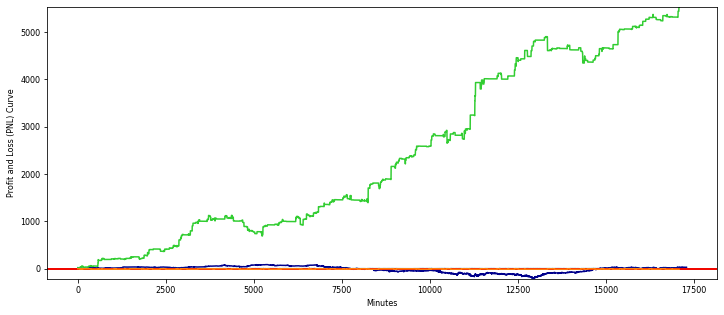

In [40]:
#Main visualization step:
from cupy import asnumpy
def plotPricesSpreadPos(P,pts,ErrorSignalWindow,PeakTotalInvestedEquity,
                        PNLPortfolioTotalVec,errorsNormStock,N,xview=1650):
    lab = P.columns.values.tolist()[1:31] #tickers aka labels
    columns = np.min([N,3])
    fig = plt.figure(figsize=(12,columns*5)) #lay out overall size
    fig.tight_layout(pad=0.0)
    plt.rc('font',size=8)
    for assetID in range(0,N):
        tailStart  = pts.shape[0]+ErrorSignalWindow #(P.shape[0]-spread.shape[0]-1)
        tailFinish = xview+tailStart #(P.shape[0]+1) #these 2 are offset by ErrorSignalWindow
        print(tailStart,tailFinish)
        pnlvec = asnumpy(PNLPortfolioTotalVec)[tailStart:tailFinish]/1.0
        pvec = ((P[lab[assetID]][tailStart:tailFinish]/
            P[lab[assetID]][tailStart]).values-1)*xview/10 #-1 makes it a gross return
        pnlmax = int(np.round(np.max(pnlvec)))
        pmin = int(np.round(np.min(pvec)))
        pmax = int(np.round(np.max(pvec)))

        #Set ylim and plot spread:
        ax = fig.add_subplot(int(np.ceil(N/columns)),columns,assetID+1)
        ax.set_ylim(np.min([-11.0,pmin]),np.max([11.0,pmax,pnlmax]))
        plt.ticklabel_format(axis='x',style='plain')
        #ax.set_ylim(-PeakTotalInvestedEquity/1000.0, PeakTotalInvestedEquity/1000.0)
        #Plot price rep as gross returns starting at 1.0
        ax.plot(pvec, #convert to net return from gross return and scale to window height
            color="darkblue") #orig prices
        if N==1:
            ax.plot(pnlvec,color="limegreen")#PNLcurve
        ax.plot(asnumpy(errorsNormStock[:,assetID]).\
                reshape(errorsNormStock.shape[0],1)\
                [tailStart:tailFinish])

        ax.axhline(Ts['T1'], color="green")
        ax.axhline(-Ts['T1'], color="green")
        ax.axhline(Ts['T2'], color="red")
        ax.axhline(-Ts['T2'], color="red")

        ax.plot(np.delete(asnumpy(pos), 0, axis=0)[:,assetID][tailStart:tailFinish]*10)
        if(assetID == 0):
            plt.ylabel(lab[assetID]+
                ' Spread (ltblue),\nPosition (orange) (Long:+,\nShort:-,None:0)')
        else:
            plt.ylabel(lab[assetID])
        if(N==1): plt.ylabel('Profit and Loss (PNL) Curve') #override
        plt.xlabel('Days') if P.shape[0] <= 300 else plt.xlabel('Minutes')
    fig.subplots_adjust(hspace=.1,wspace=.3)
plotPricesSpreadPos(P.to_pandas(),cupy.asarray(pts),ErrorSignalWindow,PeakTotalInvestedEquity,
                       PNLPortfolioTotalVec,errorsNormStock,N=1,xview=P.shape[0])
computeSR(PNLPortfolioTotalVec)